In [0]:
## По материалам:
#1. https://github.com/sar-gupta/convisualize_nb/blob/master/cnn-visualize.ipynb
#2. https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [0]:
## Домашнее задание
#1. Возьмите MNIST, обучите на нем сетку (LeNet)
#2. Возьмите какую-нить картинку (из mnist'а)
#3. Обучите шум, который при добавлении к оригинальной картинке, 
#   заставит ее ошибаться в пользу другого класса

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

import numpy as np
import scipy.misc
from PIL import Image
import json

import torchvision as tv
import time
import matplotlib.pyplot as plt
%matplotlib inline

BATCH_SIZE=256

train_dataset = tv.datasets.MNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.MNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


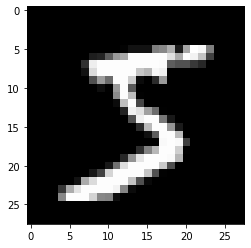

In [2]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray')

In [0]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)


In [0]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [0]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
model = model.to(dev)

In [0]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [8]:
lr, num_epochs = 0.001, 15
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.7598, train acc 0.765, test acc 0.963, time 10.8 sec
epoch 2, loss 0.0999, train acc 0.968, test acc 0.976, time 10.5 sec
epoch 3, loss 0.0702, train acc 0.978, test acc 0.980, time 10.8 sec
epoch 4, loss 0.0573, train acc 0.982, test acc 0.983, time 10.5 sec
epoch 5, loss 0.0489, train acc 0.985, test acc 0.985, time 10.5 sec
epoch 6, loss 0.0430, train acc 0.987, test acc 0.985, time 10.6 sec
epoch 7, loss 0.0383, train acc 0.988, test acc 0.986, time 10.3 sec
epoch 8, loss 0.0346, train acc 0.989, test acc 0.987, time 10.4 sec
epoch 9, loss 0.0314, train acc 0.990, test acc 0.987, time 10.4 sec
epoch 10, loss 0.0289, train acc 0.991, test acc 0.987, time 10.3 sec
epoch 11, loss 0.0265, train acc 0.992, test acc 0.986, time 10.4 sec
epoch 12, loss 0.0244, train acc 0.993, test acc 0.987, time 10.3 sec
epoch 13, loss 0.0224, train acc 0.994, test acc 0.987, time 10.4 sec
epoch 14, loss 0.0205, train acc 0.994, test acc 0.988, time 10.4 sec
epoch 15, loss 0.0189, train 

In [0]:
def fgsm_attack(image, pattern, lr, data_grad):
    sign_data_grad = data_grad.sign()
    new_pattern = pattern - lr * sign_data_grad
    perturbed_image = image + new_pattern
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, new_pattern

In [0]:
from tqdm import tqdm_notebook

def test( model, device, test_loader, target, lr):
    correct = 0
    adv_examples_good = []
    incorrect = 0
    adv_examples_bad = []
    j=0
    for data, label in tqdm_notebook(test_loader):
        j+=1
        if j > 100:
          break
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if pred.item() == target.item():
            continue
        i = 0
        pattern = torch.zeros_like(data)
        while (pred.item() != target.item()) and i<200: 
            loss = F.nll_loss(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            perturbed_data, pattern = fgsm_attack(data, pattern, lr, data_grad)
            output = model(perturbed_data)
            pred = output.max(1, keepdim=True)[1]
            i+=1
        if pred.item() == target.item():
            correct += 1
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_ex_pattern = pattern.squeeze().detach().cpu().numpy()
            adv_examples_good.append( (label.item(), pred.item(), adv_ex, adv_ex_pattern) )
        else:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_ex_pattern = pattern.squeeze().detach().cpu().numpy()
            adv_examples_bad.append( (label.item(), pred.item(), adv_ex, adv_ex_pattern) )
    return adv_examples_good, adv_examples_bad

In [0]:
from torchvision import datasets, transforms
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)
use_cuda=True


In [84]:
target =torch.Tensor([8]).long()
ex_good, ex_bad = test(model, dev, test_loader, target, 0.001)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


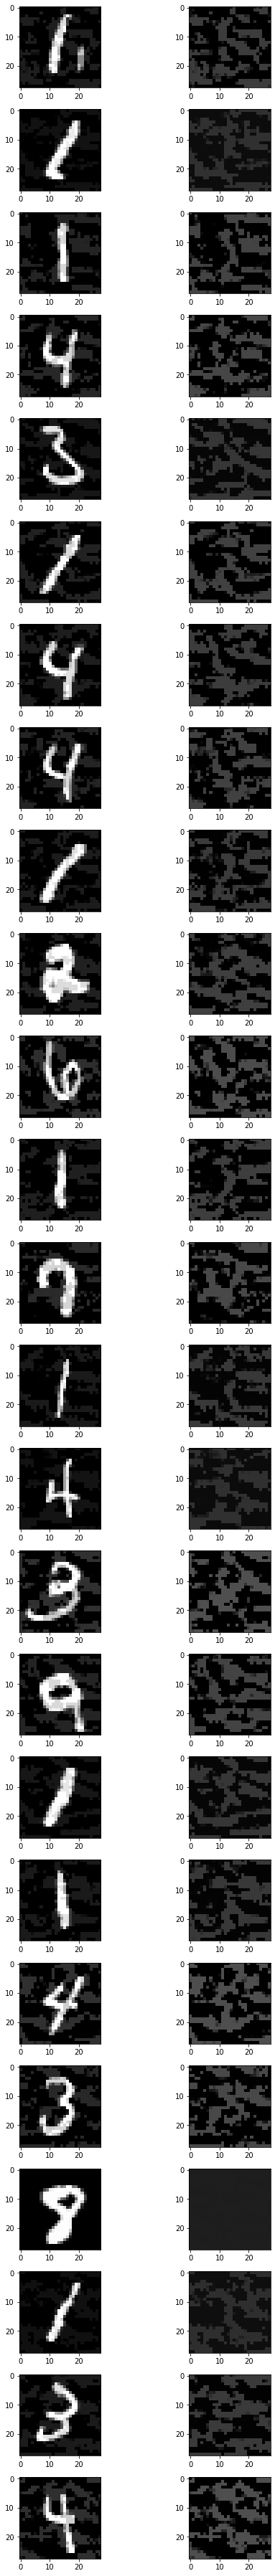

In [85]:
cnt = 0
l = len(ex_good) if len(ex_good) < 25 else 25
fig, axs = plt.subplots(l,2,figsize=(8,50))
for j in range(l):
    label,pred,ex,ptrn = ex_good[j]
    axs[j,0].imshow(ex, cmap="gray")
    axs[j,1].imshow(ptrn+np.abs(((ex_good[0][3]).min())), cmap="gray",vmin=0, vmax=1)
plt.tight_layout()
plt.show()